<a href="https://colab.research.google.com/github/solalducloyer/EI_ST4_Groupe1/blob/main/Search_Engine_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Notebook

This notebook is your search engine. 

For testing your work, we will run each cell. Thus, your code we'll have to fit the structure expected.



## Initialisation

- Install libraries (if you use Colab and needed),
- Import the modules,
- Declare global variable


In [1]:
!pip install nltk
!python -m textblob.download_corpora
!pip install beautifulsoup4
!pip install -U sentence-transformers --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━

In [2]:
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Only if you use Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A adapter !

In [8]:
DATAPATH = 'drive/MyDrive/EI_web_data/Data'
#DATAPATH = 'C:/Users/marwa/OneDrive - CentraleSupelec/Documents/EI ST_4/EI_ST4_Groupe1/Data'

###Save and load data

In [5]:
# Save and Load your data in Pickle format

def save_data(savepath, file_name, obj):
    with open(os.path.join(savepath, file_name), 'wb') as file:
      pickle.dump(obj, file)

def load_data(savepath, file_name):
    with open(os.path.join(savepath, file_name),'rb') as file:
      return pickle.load(file)

## Extraction the data

In [6]:
def remove_tags(text:str)->str:
  '''retire les balises html du texte'''
  soup = BeautifulSoup(text, 'html.parser')

  # Supprimer toutes les balises de script et de style
  for script in soup(['script', 'style']):
    script.extract()

  # Obtenir le texte propre sans balises
  texte_propre = soup.get_text()
  
  # Supprimer les espaces supplémentaires et les sauts de ligne
  texte_propre = re.sub(r'\s+', ' ', texte_propre)

  return texte_propre

def extract_tokens(text:str)->list:
  '''récupère (tous) les mots de chaque phrase'''
  tokens=re.findall(r'\w+', text)     
  return [token.lower() for token in tokens]

def lemmatize(tokens:list)->list:
  '''lemmatise tous les mots de la liste'''
  wnl = WordNetLemmatizer()
  return [wnl.lemmatize(token) for token in tokens]

def remove_stopwords(word_list):
  '''retire tous les stopwords de la liste'''
  return [word for word in word_list if word not in stopwords.words('english')]


def extract_data(datapath):
    df=pd.read_xml(os.path.join(datapath, 'Posts.xml'), parser="etree", encoding="utf8")
    df['CleanBody'] = df['Body'].fillna('').apply(remove_tags)
    df['Tokens'] = df['CleanBody'].apply(extract_tokens)
    df['Words']= df['Tokens'].apply(lemmatize)
    df['MeaningfullWords'] = df['Words'].apply(remove_stopwords)

    return df

The firt time you execute the code, uncomment to extract data then save it (it may take a few minutes). The next times you can just load the dataframe.

In [9]:
# df = extract_data(datapath=DATAPATH) 
# save_data(DATAPATH, 'df.pkl', df)
df=load_data(DATAPATH, 'df.pkl')

## Indexation data

In [10]:
def index_data(df:pd.DataFrame)-> set:
  ''' renvoie un dictionnaire de la forme 
  dic={mot:{id:f_id}}'''

  dic={}
  for rang in df.index:
    Words = df.loc[rang, 'Words']
    id = df.loc[rang,'Id']
    for word in Words:
      if word in dic.keys(): #si le mot est déjà apparu dans le corpus
        if id in dic[word].keys(): #si le mot est déjà apparu dans ce document
          dic[word][id]+=1
        else:
          dic[word][id]=1 #première occurence du mot dans ce document
      else:#première occurence du mot dans le corpus
        dic[word]={id: 1}

  return dic

In [11]:
# inverted_index=index_data(df)
# save_data(DATAPATH, 'inverted_index.pkl', inverted_index)
inverted_index=load_data(DATAPATH, 'inverted_index.pkl')

## Search Method

In [12]:
MODEL_ST = SentenceTransformer('all-MiniLM-L6-v2')
# embeddings = MODEL_ST.encode(df.CleanBody.values, normalize_embeddings=True)
# save_data(DATAPATH, 'embeddings.pkl', embeddings)
embeddings=load_data(DATAPATH, 'embeddings.pkl')

In [29]:
def similarity_matrix(query, df=df, embeddings=embeddings, MODEL_ST=MODEL_ST):
  encoded_query = MODEL_ST.encode([query], normalize_embeddings=True)
  matrix=cosine_similarity(encoded_query, embeddings)
  return(matrix)


def BM25(query, df=df, inverted_index=inverted_index, k1=1.5, b=0.75):
  '''retourne une copy de la dataframe avec une colonne 'ScoreBM25' contenant le score BM25 pour la requête'''
  #extraction des mots de la requête
  processed_query=lemmatize(extract_tokens(query))

  #création d'une copie de la dataframe
  df_copy=df.copy()

  #ajout d'une colonne longueur du document
  df_copy['Lenght']=df_copy['Words'].apply(lambda x : len(x))

  N=len(df_copy) #nombre de docs dans la collection
  avgdl=df_copy['Lenght'].mean() #longueur moyenne des docs

  #calcul du score de chaque document
  scores=[]
  for rang in df_copy.index:
    doc_id=df_copy.loc[rang,'Id']
    lenght=df_copy.loc[rang,'Lenght']
    s=0

    for terme in processed_query:
      if terme not in inverted_index : 
        s+=0 #le terme n'apparait ni dans le doc ni même dans le corpus --> contribution nulle au score 
      else :
        n=len(inverted_index[terme]) # nombre de documents contenants le terme
        
        IDF=math.log((N-n+0.5)/(n+0.5))
        if doc_id in inverted_index[terme]: freq=inverted_index[terme][doc_id]
        else: freq=0
        s+=IDF*freq*(k1+1)/(freq+k1*(1-b+b*lenght/avgdl))
    
    scores.append(s)

  #ajout d'une colonne 'Queryscore' à la copie de la dataframe
  df_copy['ScoreBM25']=scores

  return scores, df_copy


def scored_df(query, df=df, inverted_index=inverted_index, k1=1.5, b=0.75, m=0.7, embeddings=embeddings, MODEL_ST=MODEL_ST):
  ''' renvoie une copie de la dataframe munie des colonnes 'ScoreBM25','CosineSimilarity', 'Xmesure' et 'MMesure' 
  XMesure est le produit du score BM25 et de la mesure cosinus
  MMesure est la moyenne pondérée par m du score BM25 normalisé et de la mesure cosinus'''
  df_copy=df.copy()
  df_copy['ScoreBM25']=BM25(query, df, inverted_index, k1, b)[0]
  df_copy['CosineSimilarity'] = similarity_matrix(query, df, embeddings, MODEL_ST)[0]
  df_copy['XMesure']=df_copy['ScoreBM25']*df_copy['CosineSimilarity']
  
  A=df_copy['ScoreBM25'].max()
  df_copy['MMesure']=df_copy['ScoreBM25']*m/A + df_copy['CosineSimilarity']*(1-m)
  return df_copy


def search(query, top, mesure='MMesure', df=df, inverted_index=inverted_index, k1=1.5, b=0.75, m=0.7, embeddings=embeddings, MODEL_ST=MODEL_ST):
  df_copy=scored_df(query, df, inverted_index, k1, b, m, embeddings, MODEL_ST)
  return df_copy.nlargest(top, mesure)

In [30]:
query='what is stochastic gradient descent ?'
search(query, top=5)

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,LastEditorDisplayName,FavoriteCount,CleanBody,Tokens,Words,MeaningfullWords,ScoreBM25,CosineSimilarity,XMesure,MMesure
34094,53047,1,2019-06-01T14:17:40.917,4,265.0,"<p>As I know, Gradient Descent has three varia...",56922.0,2020-12-14T16:54:45.387,How is Stochastic Gradient Descent used like M...,<optimization><gradient-descent>,...,None,NaN,"As I know, Gradient Descent has three variants...","[as, i, know, gradient, descent, has, three, v...","[a, i, know, gradient, descent, ha, three, var...","[know, gradient, descent, ha, three, variant, ...",24.811270,0.582938,14.463426,0.874881
22952,36450,1,2018-08-04T06:36:04.657,75,137355.0,<p>What is the difference between Gradient Des...,57082.0,2021-02-07T20:51:58.520,What is the difference between Gradient Descen...,<machine-learning><neural-network><deep-learni...,...,None,NaN,What is the difference between Gradient Descen...,"[what, is, the, difference, between, gradient,...","[what, is, the, difference, between, gradient,...","[difference, gradient, descent, stochastic, gr...",21.527701,0.832111,17.913439,0.856994
45984,70271,2,2020-03-26T14:43:26.663,0,NaN,<p>Both algorithms are quite similar. The only...,92425.0,2020-12-21T16:42:32.517,None,None,...,None,NaN,Both algorithms are quite similar. The only di...,"[both, algorithms, are, quite, similar, the, o...","[both, algorithm, are, quite, similar, the, on...","[algorithm, quite, similar, difference, come, ...",23.961097,0.587242,14.070957,0.852187
37535,57795,2,2019-08-19T10:48:21.213,1,NaN,<p>You can see in the following link examples ...,79770.0,2019-08-19T10:48:21.213,None,None,...,None,NaN,You can see in the following link examples in ...,"[you, can, see, in, the, following, link, exam...","[you, can, see, in, the, following, link, exam...","[see, following, link, example, numpy, followi...",24.648790,0.507326,12.504965,0.847614
52361,81452,1,2020-09-09T14:21:57.233,0,125.0,<p>I am a student and I am studying machine le...,84229.0,2020-09-09T14:21:57.233,Why do we use stochastic gradient descent in n...,<machine-learning><neural-network><deep-learni...,...,None,NaN,I am a student and I am studying machine learn...,"[i, am, a, student, and, i, am, studying, mach...","[i, am, a, student, and, i, am, studying, mach...","[student, studying, machine, learning, focusin...",22.250149,0.713572,15.877081,0.841815


## Ranking

In [15]:
users = pd.read_xml(os.path.join(DATAPATH, 'Users.xml'), parser="etree", encoding="utf8")

In [16]:
def metadata_ranking(query, top, coef_rep, coef_viewcount):

  results = search(query, 10*top)

  posts_ids = results['Id'].tolist()

  new_scores = []
  reputation_scores = []

  for post_id in posts_ids:

    post_metadata = results.loc[results['Id'] == post_id]
    
    user_Id=post_metadata['OwnerUserId'].tolist()[0]
    user = users.loc[users['Id']==user_Id]
    reputation = user['Reputation'].tolist()
    if len(reputation) != 0:
      reputation_scores.append(reputation[0])
    else:
      reputation_scores.append(1)
    
    post_viewcount = post_metadata['ViewCount'].tolist()[0]
    post_score = post_metadata['MMesure'].tolist()[0]

    if not math.isnan(post_viewcount) :
      new_scores.append((post_score+coef_rep*math.log(reputation_scores[-1]))*math.pow(post_viewcount, coef_viewcount))
    else :
      new_scores.append(post_score+coef_rep*math.log(reputation_scores[-1]))

  results['Reputation'] = reputation_scores
  results['MetadataScore'] = new_scores

  new_ranking = results.nlargest(top, 'MetadataScore')

  return new_ranking

In [31]:
metadata_ranking(query, top=5, coef_rep=0.5, coef_viewcount=0.2)

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,CleanBody,Tokens,Words,MeaningfullWords,ScoreBM25,CosineSimilarity,XMesure,MMesure,Reputation,MetadataScore
22952,36450,1,2018-08-04T06:36:04.657,75,137355.0,<p>What is the difference between Gradient Des...,57082.0,2021-02-07T20:51:58.520,What is the difference between Gradient Descen...,<machine-learning><neural-network><deep-learni...,...,What is the difference between Gradient Descen...,"[what, is, the, difference, between, gradient,...","[what, is, the, difference, between, gradient,...","[difference, gradient, descent, stochastic, gr...",21.527701,0.832111,17.913439,0.856994,1039,46.137802
24067,37941,1,2018-09-07T18:15:11.690,10,20279.0,"<p>To my understanding, the SGD classifier, an...",58736.0,2018-09-07T18:31:58.697,What is the difference between SGD classifier ...,<machine-learning><logistic-regression><gradie...,...,"To my understanding, the SGD classifier, and L...","[to, my, understanding, the, sgd, classifier, ...","[to, my, understanding, the, sgd, classifier, ...","[understanding, sgd, classifier, logistic, reg...",19.106045,0.371866,7.104886,0.650598,674,28.397260
1109,1246,1,2014-10-10T13:34:11.543,10,8760.0,<p>let's assume that I want to train a stochas...,2576.0,2014-11-21T11:50:47.717,Stochastic gradient descent based on vector op...,<python><gradient-descent><regression>,...,let's assume that I want to train a stochastic...,"[let, s, assume, that, i, want, to, train, a, ...","[let, s, assume, that, i, want, to, train, a, ...","[let, assume, want, train, stochastic, gradien...",18.367978,0.589199,10.822403,0.694975,1717,27.154312
7770,13525,1,2016-08-18T11:35:25.867,3,3901.0,"<p>I was reading <a href=""http://rads.stackove...",13100.0,2022-08-15T12:02:09.390,Is there any book for modern optimization in P...,<beginner><tools><career><reference-request><b...,...,I was reading Modern Optimization with R (Use ...,"[i, was, reading, modern, optimization, with, ...","[i, wa, reading, modern, optimization, with, r...","[wa, reading, modern, optimization, r, use, r,...",18.758954,0.465278,8.728124,0.668829,865,21.169521
51536,80232,1,2020-08-13T14:00:00.913,4,1259.0,"<p>Which of the following is true, given the o...",85353.0,2020-08-13T14:36:28.063,Does convergence of loss function is always gu...,<loss-function><optimization>,...,"Which of the following is true, given the opti...","[which, of, the, following, is, true, given, t...","[which, of, the, following, is, true, given, t...","[following, true, given, optimal, learning, ra...",22.403807,0.510951,11.447244,0.785364,277,14.996521


## Visualising Results

In [18]:
def visualize_output(query, top, coef_rep, coef_viewcount):
    ranking = metadata_ranking(query, top, coef_rep, coef_viewcount)
    return ranking[['Id', 'Title', 'CleanBody', 'OwnerUserId', 'ScoreBM25', 'CosineSimilarity', 'MMesure', 'ViewCount', 'Reputation', 'MetadataScore']]

In [19]:
visualize_output('how sklearn working', top=10, coef_rep=0.5, coef_viewcount=0.1)

,Id,Title,CleanBody,OwnerUserId,ScoreBM25,CosineSimilarity,MMesure,ViewCount,Reputation,MetadataScore
22556,35869,How to choose the random seed?,"I understand this question can be strange, but...",54395.0,6.998337,0.320996,0.588314,5461.0,3398,11.003567
832,927,how to impute missing values on numpy array cr...,I'm working on the dataset with lots of NA val...,2854.0,7.811963,0.215736,0.613937,2809.0,715,8.628365
53541,84258,How to choose between Tensorflow and Pytorch?,Recently I've been working on a pretty vanilla...,303.0,7.164608,0.382007,0.618307,600.0,2350,8.530391
34459,53513,one-hot-encoding categorical data gives error,I am currently working on the Boston problem h...,73912.0,7.910799,0.125349,0.593770,3902.0,342,8.027517
40548,63185,sklearn.feature_selection vs xgboost feature_i...,sklearn.feature_selection vs xgboost feature_i...,83275.0,6.955838,0.404997,0.610526,241.0,2836,7.935933
26025,40670,Logistic regression score is negative,I am trying to implement logistic regression a...,51106.0,6.515500,0.422055,0.584686,10748.0,117,7.503616
5358,10476,how to make sklearn pipeline using custom model?,I want to make a sklearn pipeline using the cu...,14310.0,7.062588,0.473271,0.638513,4166.0,184,7.469954
21995,34061,sklearn.neighbors.NearestNeighbors - knn for u...,From basic theory I know that knn is a supervi...,46748.0,6.962655,0.446654,0.623503,6338.0,105,7.080898
23107,36652,How to show progress of sklearn.multioutput.Mu...,Is it possible to show the training progress o...,53890.0,8.845673,0.335291,0.722478,4681.0,103,7.077583
29632,45933,Why doesn't loss go down during Neural Net tra...,I am working on a Kaggle competition and have ...,16111.0,7.063059,0.314506,0.590917,959.0,292,6.813756


## Testing

In [32]:
# Lire le fichier Excel et charger les données dans un DataFrame
evaluation = pd.read_excel(DATAPATH + "/evaluation_search_engine_post_queries_ranking_EI_CS.xlsx")
liste_id=list(evaluation.PostId.values)
queries=list(evaluation.columns)[3:]
dic_performances={'rappel':[],
     'precision':[],
     'precision moyenne':[],
     'R-precision':[]
     }
N=len(evaluation) #nombre de docs pris en compte

for query in queries:
  results=search(query[10:], top=len(df), mesure = 'MMesure').loc[df['Id'].isin(liste_id)]
  #nombre de documents pertinents pour la requête
  n=evaluation[query].notna().sum()
  

  #rappel
  r=0
  dic_performances['rappel'].append([])
  for i in results.index:
    Id=results.loc[i,'Id']
    rang_attendu=evaluation.loc[evaluation['PostId']==Id, query].values[0]
    if pd.notna(rang_attendu)==True:
      r+=1
    dic_performances['rappel'][-1].append(r/n)
  
  #precision
  p=0
  k=0
  dic_performances['precision'].append([])
  for i in results.index:
    k+=1
    Id=results.loc[i,'Id']
    rang_attendu=evaluation.loc[evaluation['PostId']==Id, query].values[0]
    if pd.notna(rang_attendu)==True:
      p+=1
    dic_performances['precision'][-1].append(p/k)

  #precision moyenne
  pm=0
  k=0
  j=1
  for i in results.index:
    k+=1
    Id=results.loc[i,'Id']
    rang_attendu=evaluation.loc[evaluation['PostId']==Id, query].values[0]
    if pd.notna(rang_attendu)==True:
      pm+=j/k
      j+=1
  dic_performances['precision moyenne'].append(pm/n)

  #R-precision
  dic_performances['R-precision'].append(dic_performances['precision'][-1][int(n)])

performances=pd.DataFrame(dic_performances)

In [33]:
performances

,rappel,precision,precision moyenne,R-precision
0,"[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333...",1.000000,0.666667
1,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, ...",1.000000,0.833333
2,"[0.16666666666666666, 0.3333333333333333, 0.5,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428...",1.000000,0.857143
3,"[0.16666666666666666, 0.16666666666666666, 0.3...","[1.0, 0.5, 0.6666666666666666, 0.75, 0.6, 0.66...",0.708965,0.571429
4,"[0.25, 0.5, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 1...","[1.0, 1.0, 1.0, 0.75, 0.6, 0.6666666666666666,...",0.916667,0.600000


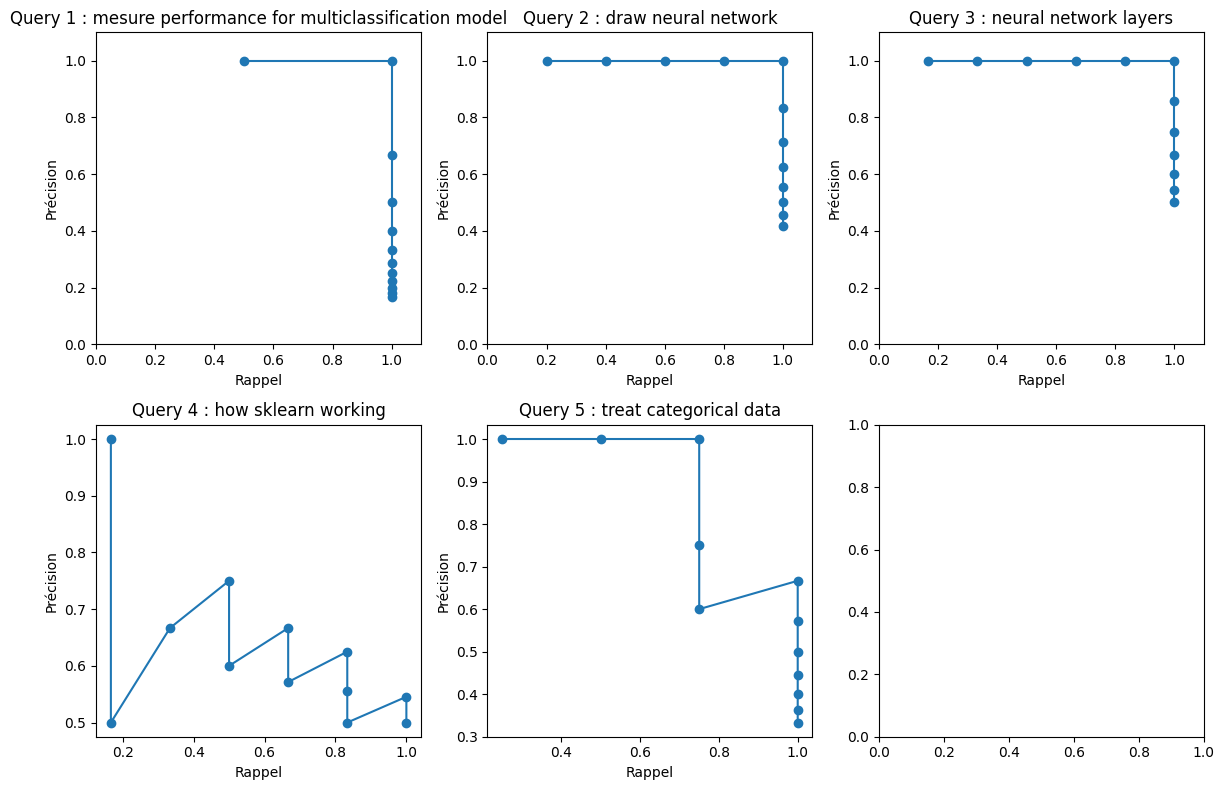

In [34]:
#Affichage des courbes rappel-precision

# Créer une grille de sous-graphes avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))


for i in range(3):
  rappel, precision=dic_performances['rappel'][i], dic_performances['precision'][i]
  axes[0, i].plot(rappel, precision ,marker='o', linestyle='-')
  axes[0, i].set_xlabel('Rappel')
  axes[0, i].set_ylabel('Précision')
  axes[0, i].set_title(queries[i])
  axes[0, i].set_xlim(0, 1.1)  # Définir les limites des axes x de 0 à 1
  axes[0, i].set_ylim(0, 1.1) 

for j in range(2):
  i=j+3
  rappel, precision=dic_performances['rappel'][i], dic_performances['precision'][i]
  axes[1, j].plot(rappel, precision ,marker='o', linestyle='-')
  axes[1, j].set_xlabel('Rappel')
  axes[1, j].set_ylabel('Précision')
  axes[1, j].set_title(queries[i])
  axes[0, j].set_xlim(0, 1.1)  # Définir les limites des axes x de 0 à 1
  axes[0, j].set_ylim(0, 1.1) 



plt.tight_layout()
plt.show()

# Interface graphique

In [35]:
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
from tkinter import font
import tkinter.font as font

In [ ]:
window = tk.Tk()
window.title("Moteur de recherche")
myFont = font.Font(family='Calibri')

In [ ]:
def search_query():
    query = entry_query.get()
    top = int(entry_top.get())
    # Récupère les résultats
    results = metadata_ranking(query, top, coef_rep=0.5, coef_viewcount=0.1)
    # Récupère les 2 colonnes titre et CleanBody
    filtered_results = results[["Title", "CleanBody"]]
     # Convertit les résultats en chaine de caractères avec des séparateurs
    result = ""
    for row in filtered_results.itertuples(index=False):
        title, clean_body = row
        result += f"Title: {title}\n{clean_body}\n{'-' * 50}\n"
        result_area.insert(tk.END, f" {title}\n", 'bold')
        result_area.insert(tk.END, f"{clean_body}\n{'-' * 50}\n")
    result_area.config(state=tk.DISABLED)

# C'est pour ajouter query, top à côté des zones où faut mettre requête et nombre de documents souhaités
#En gros les 2 entrées de la fonction view_count_ranking
label_font = font.Font(size=6)
label_query = tk.Label(window, text="Query:")
label_query.grid(row=0, column=0, padx=10, pady=10)
label_query['font'] = myFont
label_top = tk.Label(window, text="Nombre de résultats:")
label_top.grid(row=1, column=0, padx=10, pady=10)
label_top['font'] = myFont
# Zones où l'utilisateur rentre sa requête et sa 
style = ttk.Style()
style.configure('Custom.TEntry', bordercolor='gray', borderwidth=2, relief='groove')

entry_font = font.Font(size=2, font=myFont)  
entry_query = ttk.Entry(window,style='Custom.TEntry')
entry_query.grid(row=0, column=1, padx=10, pady=10, sticky="ew")
entry_top = ttk.Entry(window,style='Custom.TEntry')
entry_top.grid(row=1, column=1, padx=10, pady=10, sticky="ew")

# Caractéristiques du bouton search
#button_font = font.Font( font= myFont,size=6)
button = tk.Button(window, text="Search", command=search_query, font = (myFont,4))
button.grid(row=0, column=2, rowspan=2, padx=5, pady=5, sticky="nsew")
button['font'] = myFont
button['width'] = 1  # Adjust the width value to make the button smaller
button['height'] = 1  # Adjust the height value to make the button smaller

# Scroll_bar et zone d'affichage des résultats
result_font = myFont,font.Font(size=4)
result_area = tk.Text(window, height=10, width=50, font=myFont)
result_area.grid(row=2, column=0, columnspan=3, padx=10, pady=10, sticky="nsew")
scrollbar = tk.Scrollbar(window, command=result_area.yview)
scrollbar.grid(row=2, column=3, sticky="ns")
result_area.config(yscrollcommand=scrollbar.set)
result_area.tag_configure('bold', font=(myFont, 12, 'bold'))

# Ajuster la taille de la fenêtre
window.grid_columnconfigure(0, weight=1)
window.grid_columnconfigure(1, weight=1)
window.grid_columnconfigure(2, weight=1)
window.grid_rowconfigure(0, weight=0)
window.grid_rowconfigure(1, weight=0)
window.grid_rowconfigure(2, weight=1)

In [ ]:
window.mainloop()